In [25]:
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.transforms as Transforms
from torch.utils.data import random_split, DataLoader, Dataset
import copy
import pickle
from utils import set_seed
from utils.eval import train
from models.backbone import Backbone
from models.classifier import Classifier
from augmentations.loader import npy_loader
from augmentations import ImageDataset
from utils.eval import test_
from sklearn.metrics import confusion_matrix, roc_curve, auc
set_seed(12)

In [26]:
eval_transforms = Transforms.Compose([
                # Transforms.ToTensor(), # npy loader returns torch.Tensor
                Transforms.CenterCrop(64),
                Transforms.Normalize(mean = [0.06814773380756378, 0.21582692861557007, 0.4182431399822235],\
                                        std = [0.16798585653305054, 0.5532506108283997, 1.1966736316680908]),
            ])

train_test_indices = "../input/indices.pkl"
data_path = "../input/real_lenses_dataset/"

indices = None
with open(train_test_indices, "rb") as f:
    indices = pickle.load(f)
    
# test images and labels
test_paths = [os.path.join(data_path, *["lenses", img]) for img in np.array(indices["test"]["lenses"])] +\
                [os.path.join(data_path, *["nonlenses", img]) for img in np.array(indices["test"]["nonlenses"])]
test_labels = [0]*len(indices["test"]["lenses"]) + [1]*len(indices["test"]["nonlenses"])

test_dataset = ImageDataset(
    image_paths=test_paths,
    labels=test_labels,
    loader=npy_loader,
    transform=eval_transforms
)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=False,
)

def plot_(y_test, y_pred1, y_pred2, y_score1, y_score2, model1_name, model2_name):

    cm1 = confusion_matrix(y_test, y_pred1)
    cm2 = confusion_matrix(y_test, y_pred2)
    
    fpr1, tpr1, _ = roc_curve(y_test, y_score1)
    roc_auc1 = auc(fpr1, tpr1)
    
    fpr2, tpr2, _ = roc_curve(y_test, y_score2)
    roc_auc2 = auc(fpr2, tpr2)
    
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 2])
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(cm1, interpolation='nearest', cmap=plt.cm.Blues)
    ax1.set_title(f'Confusion Matrix for\n{model1_name}')
    tick_marks = np.arange(2)
    ax1.set_xticks(tick_marks)
    ax1.set_yticks(tick_marks)
    ax1.set_xticklabels(['0', '1'])
    ax1.set_yticklabels(['0', '1'])
    
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.imshow(cm2, interpolation='nearest', cmap=plt.cm.Blues)
    ax2.set_title(f'Confusion Matrix for\n{model2_name}')
    ax2.set_xticks(tick_marks)
    ax2.set_yticks(tick_marks)
    ax2.set_xticklabels(['0', '1'])
    ax2.set_yticklabels(['0', '1'])
    
    for i, j in np.ndindex(cm1.shape):
        ax1.text(j, i, format(cm1[i, j], 'd'), ha="center", va="center", color="black")
        ax2.text(j, i, format(cm2[i, j], 'd'), ha="center", va="center", color="black")
    
    ax3 = fig.add_subplot(gs[:, 1])
    ax3.plot(fpr1, tpr1, color='blue', lw=2, label=f'{model1_name} (area = {roc_auc1:.2f})')
    ax3.plot(fpr2, tpr2, color='green', lw=2, label=f'{model2_name} (area = {roc_auc2:.2f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('Receiver Operating Characteristic')
    ax3.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig(f'cm_roc_{model1_name.replace(" ", "_").replace("/", "_").replace("-", "_")}_{model2_name.replace(" ", "_").replace("/", "_").replace("-", "_")}.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

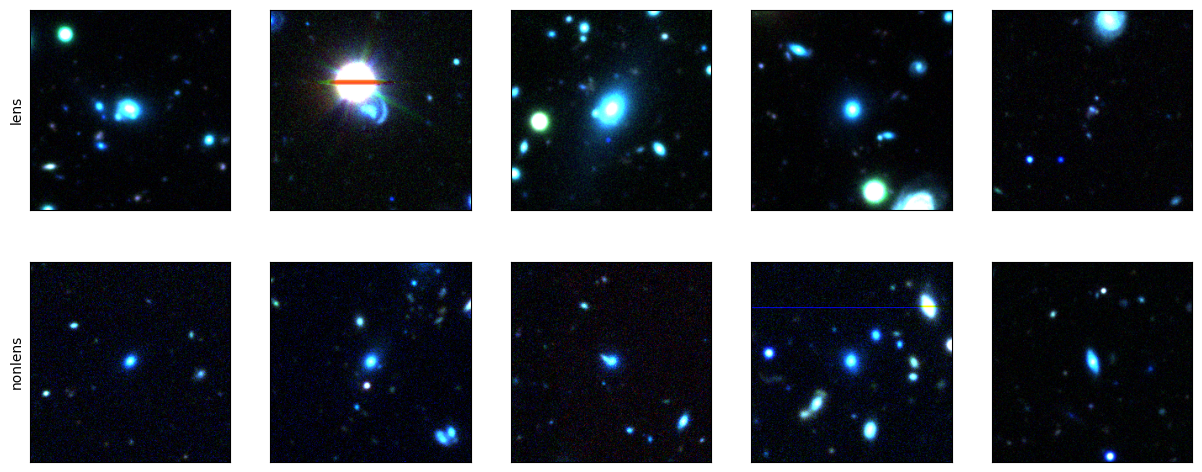

In [55]:
lens_train_paths = [os.path.join(data_path, *["lenses", img]) for img in np.array(indices["train"]["lenses"])] 
nonlens_train_paths = [os.path.join(data_path, *["nonlenses", img]) for img in np.array(indices["train"]["nonlenses"])]

fig, axs = plt.subplots(2, 5, figsize = (15, 6))
axs[0][0].set_ylabel("lens")
axs[1][0].set_ylabel("nonlens")
for i in range(2):
    for j in range(5):
        img = None        
        if i == 0:
            img = np.dstack(np.load(lens_train_paths[j]))
        else:
            img = np.dstack(np.load(nonlens_train_paths[j]))
        axs[i][j].imshow(img)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        

### Supervised

In [6]:
supervised_vit_small_state_path = "../working/1407/supervised/state_vit_small.pth"
with open(supervised_vit_small_state_path, "rb") as f:
    supervised_vit_small_state = pickle.load(f)

supervised_vit_small_model = supervised_vit_small_state["network"]
supervised_vit_small_output, supervised_vit_small_y_true, supervised_vit_small_acc, supervised_vit_small_auc = test_(supervised_vit_small_model, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       262        |          31         |
| true nonlenses |        20        |         280         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 91.3997% |
|    loss   |  0.0000  |
| auc score |  0.9780  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9291  | 0.8942 |  0.9113 |   293   |
|   nonlenses    |   0.9003  | 0.9333 |  0.9165 |   300   |
| macro averaged |   0.9147  | 0.9138 |  0.9139 |         |
+----------------+-----------+--------+---------+---------+


In [8]:
supervised_vit_base_state_path = "../working/1407/supervised/state_vit_base.pth"
with open(supervised_vit_base_state_path, "rb") as f:
    supervised_vit_base_state = pickle.load(f)

supervised_vit_base_model = supervised_vit_base_state["network"]
supervised_vit_base_output, supervised_vit_base_y_true, supervised_vit_base_acc, supervised_vit_base_auc = test_(supervised_vit_base_model, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       262        |          31         |
| true nonlenses |        15        |         285         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 92.2428% |
|    loss   |  0.0000  |
| auc score |  0.9762  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9458  | 0.8942 |  0.9193 |   293   |
|   nonlenses    |   0.9019  | 0.9500 |  0.9253 |   300   |
| macro averaged |   0.9239  | 0.9221 |  0.9223 |         |
+----------------+-----------+--------+---------+---------+


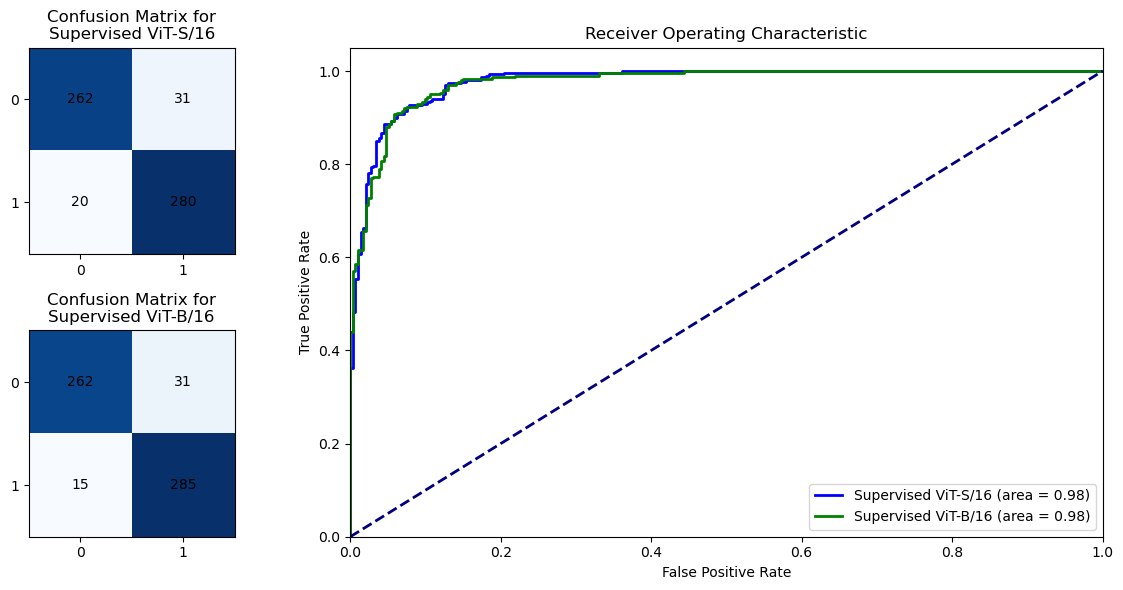

In [9]:
y_test = dino_vit_base_y_true
y_pred1 = (np.argmax(dino_vit_small_output, axis=-1)).astype(np.float16)
y_pred2 = (np.argmax(dino_vit_base_output, axis=-1)).astype(np.float16)
y_score1 = np.array(dino_vit_small_output)[:,1]
y_score2 = np.array(dino_vit_base_output)[:,1]
model1_name = "Supervised ViT-S/16"
model2_name = "Supervised ViT-B/16"

plot_(y_test, y_pred1, y_pred2, y_score1, y_score2, model1_name, model2_name)

### SimSiam

In [10]:
# simsiam vit small

simsiam_vit_small_path = "../working/1407/simsiam_vit_small_patch_16/classifier_network.pth"
with open(simsiam_vit_small_path, "rb") as f:
    simsiam_vit_small_model = pickle.load(f)

simsiam_vit_small_output, simsiam_vit_small_y_true, simsiam_vit_small_acc, simsiam_vit_small_auc = test_(simsiam_vit_small_model, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       260        |          33         |
| true nonlenses |        17        |         283         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 91.5683% |
|    loss   |  0.0000  |
| auc score |  0.9703  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9386  | 0.8874 |  0.9123 |   293   |
|   nonlenses    |   0.8956  | 0.9433 |  0.9188 |   300   |
| macro averaged |   0.9171  | 0.9154 |  0.9156 |         |
+----------------+-----------+--------+---------+---------+


In [11]:
# simsiam vit base

simsiam_vit_base_path = "../working/1407/simsiam_vit_base_patch_16/classifier_network.pth"
with open(simsiam_vit_base_path, "rb") as f:
    simsiam_vit_base_model = pickle.load(f)

simsiam_vit_base_output, simsiam_vit_base_y_true, simsiam_vit_base_acc, simsiam_vit_base_auc = test_(simsiam_vit_base_model, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       264        |          29         |
| true nonlenses |        21        |         279         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 91.5683% |
|    loss   |  0.0028  |
| auc score |  0.9651  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9263  | 0.9010 |  0.9135 |   293   |
|   nonlenses    |   0.9058  | 0.9300 |  0.9178 |   300   |
| macro averaged |   0.9161  | 0.9155 |  0.9156 |         |
+----------------+-----------+--------+---------+---------+


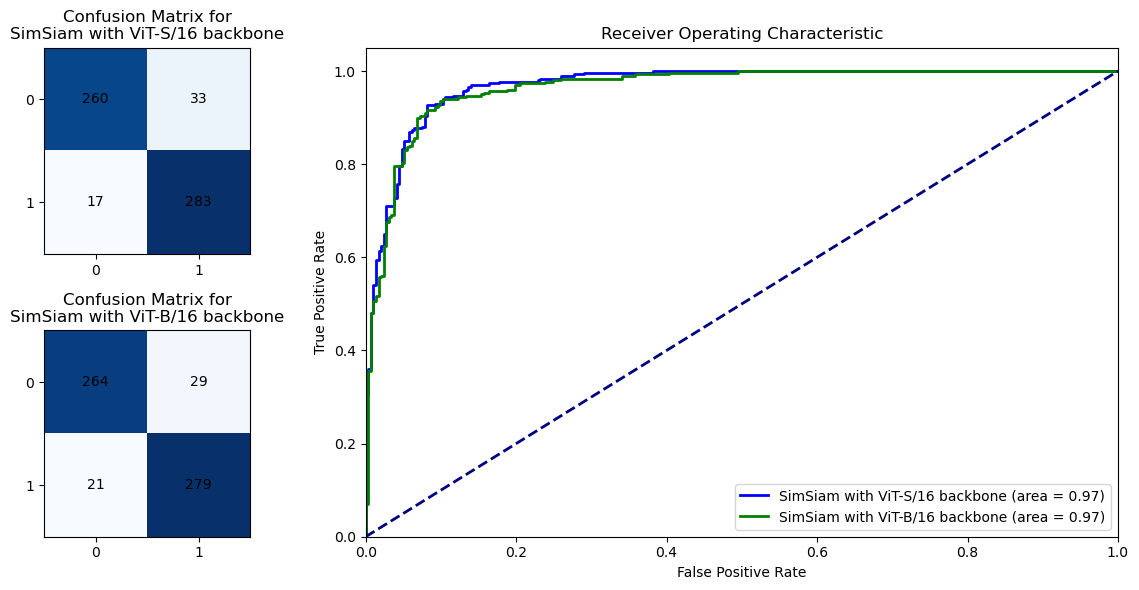

In [12]:
y_test = simsiam_vit_base_y_true
y_pred1 = (np.argmax(simsiam_vit_small_output, axis=-1)).astype(np.float16)
y_pred2 = (np.argmax(simsiam_vit_base_output, axis=-1)).astype(np.float16)
y_score1 = np.array(simsiam_vit_small_output)[:,1]
y_score2 = np.array(simsiam_vit_base_output)[:,1]
model1_name = "SimSiam with ViT-S/16 backbone"
model2_name = "SimSiam with ViT-B/16 backbone"

plot_(y_test, y_pred1, y_pred2, y_score1, y_score2, model1_name, model2_name)

### iBot

In [17]:
# ibot vit small

ibot_vit_small_path = "../working/1407/ibot_vit_small_patch_16/classifier_network.pth"
with open(ibot_vit_small_path, "rb") as f:
    ibot_vit_small_model = pickle.load(f)

ibot_vit_small_output, ibot_vit_small_y_true, ibot_vit_small_acc, ibot_vit_small_auc = test_(ibot_vit_small_model, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       261        |          32         |
| true nonlenses |        17        |         283         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 91.7369% |
|    loss   |  0.0002  |
| auc score |  0.9720  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9388  | 0.8908 |  0.9142 |   293   |
|   nonlenses    |   0.8984  | 0.9433 |  0.9203 |   300   |
| macro averaged |   0.9186  | 0.9171 |  0.9173 |         |
+----------------+-----------+--------+---------+---------+


In [18]:
# ibot vit base

ibot_vit_base_path = "../working/1407/ibot_vit_base_patch_16/classifier_network.pth"
with open(ibot_vit_base_path, "rb") as f:
    ibot_vit_base_model = pickle.load(f)

ibot_vit_base_output, ibot_vit_base_y_true, ibot_vit_base_acc, ibot_vit_base_auc = test_(ibot_vit_base_model, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       261        |          32         |
| true nonlenses |        21        |         279         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 91.0624% |
|    loss   |  0.0001  |
| auc score |  0.9689  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9255  | 0.8908 |  0.9078 |   293   |
|   nonlenses    |   0.8971  | 0.9300 |  0.9133 |   300   |
| macro averaged |   0.9113  | 0.9104 |  0.9105 |         |
+----------------+-----------+--------+---------+---------+


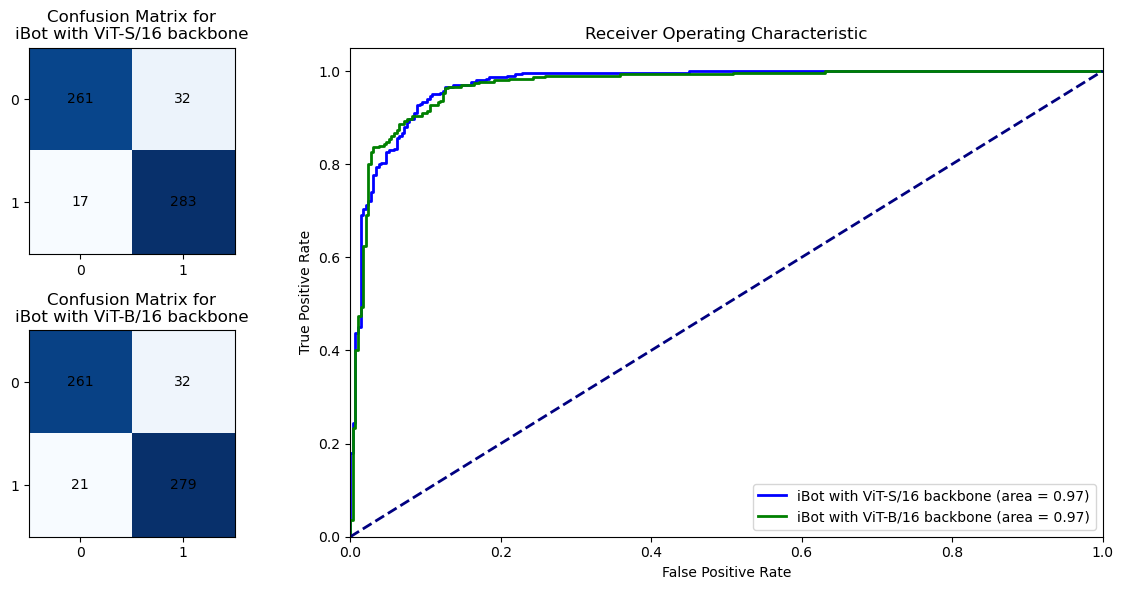

In [19]:
y_test = ibot_vit_base_y_true
y_pred1 = (np.argmax(ibot_vit_small_output, axis=-1)).astype(np.float16)
y_pred2 = (np.argmax(ibot_vit_base_output, axis=-1)).astype(np.float16)
y_score1 = np.array(ibot_vit_small_output)[:,1]
y_score2 = np.array(ibot_vit_base_output)[:,1]
model1_name = "iBot with ViT-S/16 backbone"
model2_name = "iBot with ViT-B/16 backbone"

plot_(y_test, y_pred1, y_pred2, y_score1, y_score2, model1_name, model2_name)

### DINO

In [20]:
# dino vit small

dino_vit_small_path = "../working/1407/dino_vit_small-20240716-005817/classifier_network.pth"
with open(dino_vit_small_path, "rb") as f:
    dino_vit_small_model = pickle.load(f)

dino_vit_small_output, dino_vit_small_y_true, dino_vit_small_acc, dino_vit_small_auc = test_(dino_vit_small_model, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       268        |          25         |
| true nonlenses |        11        |         289         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 93.9292% |
|    loss   |  0.0000  |
| auc score |  0.9782  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9606  | 0.9147 |  0.9371 |   293   |
|   nonlenses    |   0.9204  | 0.9633 |  0.9414 |   300   |
| macro averaged |   0.9405  | 0.9390 |  0.9392 |         |
+----------------+-----------+--------+---------+---------+


In [22]:
# dino vit bse

dino_vit_base_path = "../working/1407/dino_vit_base-20240716-193405/classifier_network.pth"
with open(dino_vit_base_path, "rb") as f:
    dino_vit_base_model = pickle.load(f)

dino_vit_base_output, dino_vit_base_y_true, dino_vit_base_acc, dino_vit_base_auc = test_(dino_vit_base_model, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       266        |          27         |
| true nonlenses |        15        |         285         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 92.9174% |
|    loss   |  0.0000  |
| auc score |  0.9785  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9466  | 0.9078 |  0.9268 |   293   |
|   nonlenses    |   0.9135  | 0.9500 |  0.9314 |   300   |
| macro averaged |   0.9300  | 0.9289 |  0.9291 |         |
+----------------+-----------+--------+---------+---------+


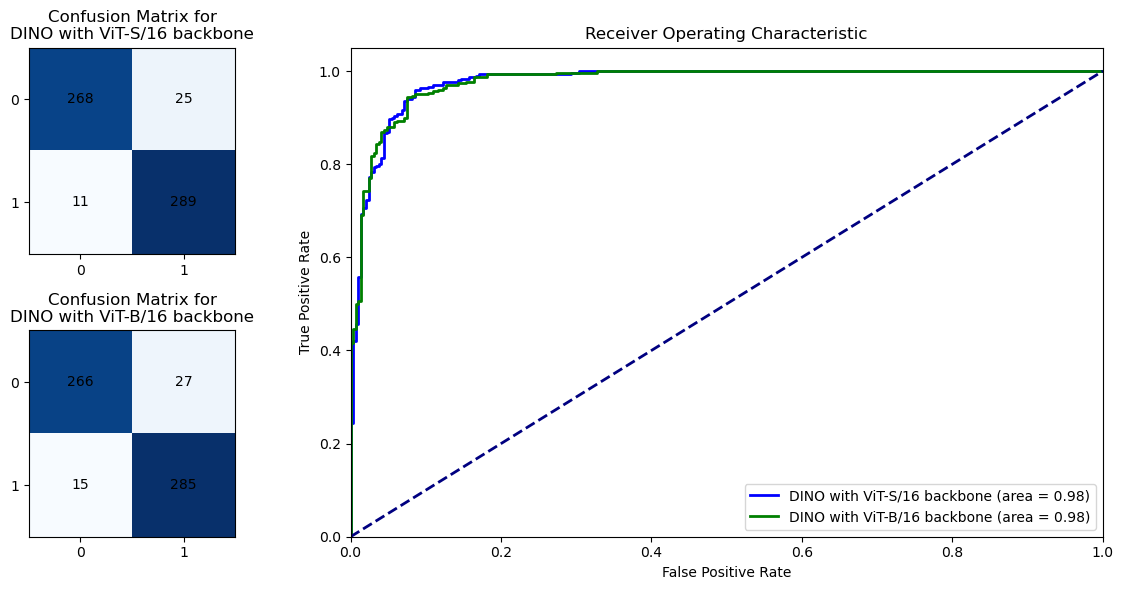

In [23]:
y_test = dino_vit_base_y_true
y_pred1 = (np.argmax(dino_vit_small_output, axis=-1)).astype(np.float16)
y_pred2 = (np.argmax(dino_vit_base_output, axis=-1)).astype(np.float16)
y_score1 = np.array(dino_vit_small_output)[:,1]
y_score2 = np.array(dino_vit_base_output)[:,1]
model1_name = "DINO with ViT-S/16 backbone"
model2_name = "DINO with ViT-B/16 backbone"

plot_(y_test, y_pred1, y_pred2, y_score1, y_score2, model1_name, model2_name)

## Evaluation Results

In [24]:
print(f"fine-tuning results on held-out test dataset)")
t = PrettyTable(["model", "accuracy", "auc score"])
t.add_row(["Supervised ViT-Small/16+linear (Baseline)", f"{supervised_vit_small_acc:.4f}", f"{supervised_vit_small_auc:.4f}"])
t.add_row(["Supervised ViT-Base/16+linear (Baseline)", f"{supervised_vit_base_acc:.4f}", f"{supervised_vit_base_auc:.4f}"])
t.add_row(["SSL DINO ViT-Small/16+linear (embed dim: 384, patch size: 16)", f"{dino_vit_small_acc:.4f}", f"{dino_vit_small_auc:.4f}"])
t.add_row(["SSL DINO ViT-Base/16+linear (embed dim: 768, patch size: 16)", f"{dino_vit_base_acc:.4f}", f"{dino_vit_base_auc:.4f}"])
t.add_row(["SSL iBot ViT-Small/16+linear (embed dim: 384, patch size: 16)", f"{ibot_vit_small_acc:.4f}", f"{ibot_vit_small_auc:.4f}"])
t.add_row(["SSL iBot ViT-Base/16+linear (embed dim: 768, patch size: 16)", f"{ibot_vit_base_acc:.4f}", f"{ibot_vit_base_auc:.4f}"])
t.add_row(["SSL simsiam ViT-Small/16+linear (embed dim: 384, patch size: 16)", f"{simsiam_vit_small_acc:.4f}", f"{simsiam_vit_small_auc:.4f}"])
t.add_row(["SSL simsiam ViT-Base/16+linear (embed dim: 768, patch size: 16)", f"{simsiam_vit_base_acc:.4f}", f"{simsiam_vit_base_auc:.4f}"])
print(t)
print('\n')

fine-tuning results on held-out test dataset)
+------------------------------------------------------------------+----------+-----------+
|                              model                               | accuracy | auc score |
+------------------------------------------------------------------+----------+-----------+
|            Supervised ViT-Small/16+linear (Baseline)             | 91.3997  |   0.9780  |
|             Supervised ViT-Base/16+linear (Baseline)             | 92.2428  |   0.9762  |
|  SSL DINO ViT-Small/16+linear (embed dim: 384, patch size: 16)   | 93.9292  |   0.9782  |
|   SSL DINO ViT-Base/16+linear (embed dim: 768, patch size: 16)   | 92.9174  |   0.9785  |
|  SSL iBot ViT-Small/16+linear (embed dim: 384, patch size: 16)   | 91.7369  |   0.9720  |
|   SSL iBot ViT-Base/16+linear (embed dim: 768, patch size: 16)   | 91.0624  |   0.9689  |
| SSL simsiam ViT-Small/16+linear (embed dim: 384, patch size: 16) | 91.5683  |   0.9703  |
| SSL simsiam ViT-Base/16+linear (